Populating the interactive namespace from numpy and matplotlib


## Importation des données

In [2]:
dataset=pd.read_excel('fraud_transaction.xlsx')


# combien des lignes ou colonnes dans mon dataset

In [3]:
dataset.shape

(22215, 11)

** Ce dataset a 22215 lignes et 11 colonnes

 Affichage de 5 premières lignes du dataset

In [4]:
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,16,CASH_IN,171267.01,C342385813,91788.00,263055.01,C1326285041,130023.06,0.00,0,0
1,13,CASH_OUT,15149.15,C1819823204,158857.00,143707.85,C1828290290,0.00,15149.15,0,0
2,12,CASH_OUT,118064.98,C1030324341,2709701.00,2591636.02,C242783599,187337.43,305402.40,0,0
3,11,CASH_IN,122327.22,C1409524889,5297757.38,5420084.59,C1276977413,250489.72,128162.50,0,0
4,11,CASH_IN,129449.30,C818391416,177.00,129626.30,C189856885,261301.81,272398.17,0,0


##   1_Exploration  et nettoyage des données 


* L'idée c'est d'avoir des données non biaisées enfin d'avoir un modele précis
* Ma variable dependante c'est Y='isFraud' ,en fait l'exploration et le netoyage me permet de choisir les variables independantes optimales pour faire mon modèle 
* La solution de mon problème est binaire,je souhaite utiliser une regression logistique pour modeliser


# Exploration

Les différentes variables  dans le dataset

In [5]:
print(dataset.columns.tolist())

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']



*Exist il des variables non renseignées totalement?

In [6]:
dataset.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

** Toutes les variables sont totalement renseignées, aucune valeur manquante en apparence dans le dataset

In [7]:
dataset[(dataset['nameDest'].str.startswith('M'))].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
7,14,PAYMENT,5467.13,C1791489057,315.0,0.0,M1116606077,0.0,0.0,0,0
13,37,PAYMENT,8513.52,C782687583,0.0,0.0,M1973432380,0.0,0.0,0,0
16,41,PAYMENT,6863.64,C96771120,0.0,0.0,M1646603109,0.0,0.0,0,0
24,14,PAYMENT,19518.73,C895693375,0.0,0.0,M1041981071,0.0,0.0,0,0
26,12,PAYMENT,5103.98,C1208836079,0.0,0.0,M1692038307,0.0,0.0,0,0


# Mon dataset est vraiment bien rempli malgré l'absence de 'NaN'?

In [8]:
dataset[(dataset['nameDest'].str.startswith('M')&dataset['oldbalanceDest']!=0)\
        |(dataset['nameDest'].str.startswith('M')&dataset['newbalanceDest']!=0)].shape

(0, 11)

* le resultat du code precedent nous montre bien qu'aucune transaction ayant le nom du destinateur commençant par M est 
 renseigné sur les colonnes 'oldbalanceDest' et 'newbalanceDest', les valeurs manquantes sont donc remplacées par les "0".
 Mon dataset n'est pas correctement renseigné*

# La variable 'isFlaggedFraud' peut elle etre  reprensatative  de notre modele?

In [9]:
#  cette variable possède des valeurs différentes de '0'?
dataset[dataset['isFlaggedFraud']!=0].shape

(0, 11)

*  la ligne de code precedente montre bien que toutes les valeurs de la variable 'isFlaggedFraud'
sont nulles, chose étonnante car au dela d'une certaine somme la transaction devrait etre illegal.
* fraude ou pas cette valeur est la meme , chose anormale
* cette valeur ne peut pas etre  representative du modèle

# Nombre de transaction par type 

In [10]:
#nombre de transaction
dataset['type'].value_counts()


CASH_OUT    8261
PAYMENT     6859
CASH_IN     4576
TRANSFER    2379
DEBIT        140
Name: type, dtype: int64

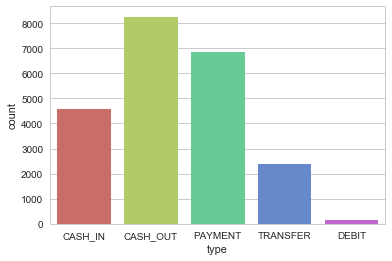

In [11]:
#representation du nombre de transaction par type de transaction
sns.countplot(x='type',data=dataset,palette='hls')


# Quels types de transaction sont concernés par les fraudes ?

In [12]:
fraude=dataset[dataset['isFraud']==1]
pas_de_fraude=dataset[dataset['isFraud']!=1]

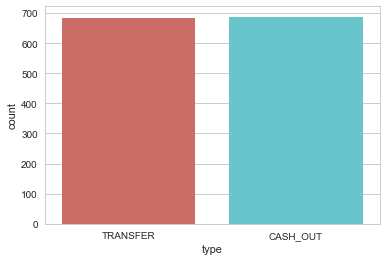

In [13]:
sns.countplot(x='type',data=fraude,palette='hls')


* Ce qui precède nous montre bien que les transactions fraudileuses sont exclusivement soit de type:'TRANSFER' ou 'CASH_OUT' par conséquent
    notre modèle sera basé que sur ces deux types de transactions

In [14]:
#dataset['isFraud'].value_counts()

# Nettoyage

# Voici en resumé ce que l'exploration des données nous a montré

* les fraudes ne sont concernées exclusivement que par deux types :
    par transert(TRANSFERT) ou par retrait en espèces(CASH_OUT)


* Aucune transaction ayant le nom du destinateur commençant par M est renseigné sur les colonnes 'oldbalanceDest' et 'newbalanceDest', les valeurs manquantes sont donc remplacées par les "0". Mon dataset n'est pas correctement renseigné


* La variable 'isFlaggedFraud'  ne peut pas etre  representative du modèle

In [15]:
# le type de notre modele est soit un tranfert ou retrait, on supprime les variables non représentatives
# Dans notre nouveau dataFrame on ne garde que les transactions de type 'TRANSFER' ou 'CASH_OUT'
dat=dataset.loc[(dataset.type=='TRANSFER')|(dataset.type=='CASH_OUT')]
dat.shape


(10640, 11)

# Exploitation des valeurs manquantes

 Nous avons supposé comme valeurs manquantes les deux cas suivants:
* debit avant=0, debit après=0 et le montant de transaction différent de 0
* credit avant=0, credit après=0 et le montant de transaction différent de 0

In [16]:
# On separe le nouveau dataFrame en dataFrame(fraude) et (sans fraude)
xfraude=dat[dat['isFraud']==1]
xpas_de_fraude=dat[dat['isFraud']!=1]

# nombre de transactions fraudileuses
print('il ya ',xfraude.shape[0],'transactions fraudileuses')
# nombre de transactions non fraudileuses
print('il ya ',xpas_de_fraude.shape[0],'transactions non fraudileuses')


il ya  1372 transactions fraudileuses
il ya  9268 transactions non fraudileuses


* Pourcentage des valeurs manquantes dans les transactions frauduleuses

In [17]:
credit=fraude.loc[(fraude.oldbalanceDest == 0) & (fraude.newbalanceDest == 0) & (fraude.amount != 0)].shape[0]
debit=fraude.loc[(fraude.oldbalanceOrg == 0) & (fraude.newbalanceOrig == 0) & (fraude.amount != 0)].shape[0]
# pourcentage des valeurs manquantes dans les transactions frauduleuses cotés debiteurs
debit_manquant_pourcent=100*debit/xfraude.shape[0]
print('Dans les transactions frauduleuses les comptes debiteurs representent'\
      ,round(debit_manquant_pourcent,2),'%','des valeurs manquantes')
# pourcentage des valeurs manquantes dans les transactions frauduleuses cotés créditeurs
credit_manquant_pourcent=100*credit/xfraude.shape[0]
print('alors que les comptes créditeurs representent',round(credit_manquant_pourcent,2),'%','des valeurs manquantes')

Dans les transactions frauduleuses les comptes debiteurs representent 1.97 % des valeurs manquantes
alors que les comptes créditeurs representent 46.87 % des valeurs manquantes


* Pourcentage des valeurs manquantes dans les transactions non frauduleuses

In [18]:
deb=xpas_de_fraude.loc[(xpas_de_fraude.oldbalanceOrg == 0)\
                   & (xpas_de_fraude.newbalanceOrig == 0)\
                   & (xpas_de_fraude.amount != 0) ].shape[0]  
cred=xpas_de_fraude.loc[(xpas_de_fraude.oldbalanceDest == 0)\
                   & (xpas_de_fraude.newbalanceDest == 0)\
                   & (xpas_de_fraude.amount != 0) ].shape[0]  


# pourcentage des valeurs manquantes dans les transactions non frauduleuses cotés debiteurs
deb_manquant_pourcent=100*deb/xpas_de_fraude.shape[0]
print('Dans les transactions non frauduleuses les comptes debiteurs representent',\
      round(deb_manquant_pourcent,2),'%','des valeurs manquantes')
# pourcentage des valeurs manquantes dans les transactions non frauduleuses cotés créditeurs
cred_manquant_pourcent=100*cred/xpas_de_fraude.shape[0]
print('alors que les comptes créditeurs representent',round(cred_manquant_pourcent,2),'%','des valeurs manquantes')

Dans les transactions non frauduleuses les comptes debiteurs representent 47.19 % des valeurs manquantes
alors que les comptes créditeurs representent 0.18 % des valeurs manquantes


* Le resultat précedent nous montre que le traitement des valeurs manquantes dependra des comptes debiteurs ou crediteurs et selon que la transaction soit fraudileuse ou non

In [19]:
# supprimons les variables peu representatives
dat.drop(['step', 'nameOrig','isFlaggedFraud','nameDest'],1,inplace=True)
dat.head()

C:\Users\CHRISTIAN NGOKIO\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
1,CASH_OUT,15149.15,158857.0,143707.85,0.00,15149.15,0
2,CASH_OUT,118064.98,2709701.0,2591636.02,187337.43,305402.40,0
5,CASH_OUT,109365.10,0.0,0.00,207150.29,520523.85,0
8,TRANSFER,116959.85,0.0,0.00,550850.91,667810.76,0
10,CASH_OUT,336447.70,291.0,0.00,0.00,336447.70,0


""" Transformation des valeurs de la variable type en 1 et 0
    pas besoin d'utiliser le module sklearn car
    on peut le faire directement """



In [20]:
dat['type'] = np.where(dat['type'] == 'TRANSFER', 1, 0)
dat = dat.reset_index(drop=True)
dat.head()

C:\Users\CHRISTIAN NGOKIO\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0,15149.15,158857.0,143707.85,0.00,15149.15,0
1,0,118064.98,2709701.0,2591636.02,187337.43,305402.40,0
2,0,109365.10,0.0,0.00,207150.29,520523.85,0
3,1,116959.85,0.0,0.00,550850.91,667810.76,0
4,0,336447.70,291.0,0.00,0.00,336447.70,0


 Traitement des valeurs manquantes
    

In [21]:
"""
Les valeurs manquantes credits on le remplace par -1 car il y avait plus des transactions frauduleuses qui avaient des valeurs 
manquantes pour les comptes crédits, cela permet à l'algorithme de differencier
"""
dat.loc[(dat.oldbalanceDest == 0) & (dat.newbalanceDest == 0) & (dat.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1

In [22]:
#Les valeurs manquantes debits on le remplace par 'NaN'
dat.loc[(dat.oldbalanceOrg == 0) & (dat.newbalanceOrig == 0) & (dat.amount != 0), \
      ['oldbalanceOrg', 'newbalanceOrig']] = np.nan
# les 'NaN' sont à leur tour remplacées par les valeurs medianes
dat[['oldbalanceOrg','newbalanceOrig']]=dat[['oldbalanceOrg','newbalanceOrig']].fillna(dat.median())
dat.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0,15149.15,158857.0,143707.85,0.00,15149.15,0
1,0,118064.98,2709701.0,2591636.02,187337.43,305402.40,0
2,0,109365.10,41676.0,0.00,207150.29,520523.85,0
3,1,116959.85,41676.0,0.00,550850.91,667810.76,0
4,0,336447.70,291.0,0.00,0.00,336447.70,0


# Après nettoyage et traitement des valeurs manquantes,je vérifie si mes variables explicatives sont independantes entre elles

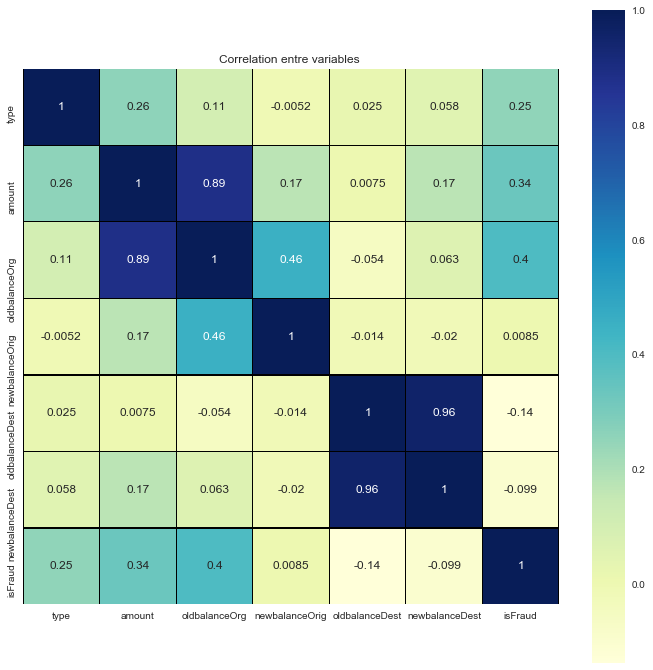

In [23]:
# affichage des corrélations entre variables
f, ax = plt.subplots(figsize=(12, 12))
plt.title('Correlation entre variables ')
sns.heatmap(dat.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True)

* iL ya une très forte correlation entre oldbalanceOrg et amount  d'une part et oldbalanceDest et newbalanceDest    d'autre part.

* On ne peut pas faire un modèle avec des variables qui ne sont pas independantes

* Nous allons créer deux variables qui seront chacune une combinaison lineaire de chaque deux variables corréelées et du montant de la transaction

In [24]:
d_model=pd.DataFrame(dat)

In [25]:

d_model['errorBalanceSender'] = d_model.oldbalanceOrg  -d_model.amount - d_model.newbalanceOrig
d_model['errorBalanceReceiver'] = d_model.oldbalanceDest + d_model.amount - d_model.newbalanceDest
d_model.drop(['oldbalanceOrg', 'oldbalanceDest'], 1, inplace=True)
d_model = d_model.rename(columns={'newbalanceOrig':'balanceSender', 'newbalanceDest':'balanceReceiver'})
d_model['noErrors'] = np.where((d_model['errorBalanceSender'] == 0) & (d_model['errorBalanceReceiver'] == 0), 1, 0)
d_model.head(5)





,type,amount,balanceSender,balanceReceiver,isFraud,errorBalanceSender,errorBalanceReceiver,noErrors
0,0,15149.15,143707.85,15149.15,0,0.00,0.00,1
1,0,118064.98,2591636.02,305402.40,0,0.00,0.01,0
2,0,109365.10,0.00,520523.85,0,-67689.10,-204008.46,0
3,1,116959.85,0.00,667810.76,0,-75283.85,0.00,0
4,0,336447.70,0.00,336447.70,0,-336156.70,0.00,0


In [26]:
d_model['noErrors'].value_counts()

0    9982
1     658
Name: noErrors, dtype: int64

# Après créations des nouvelles variables,je vérifie  à nouveau l'independance des variables

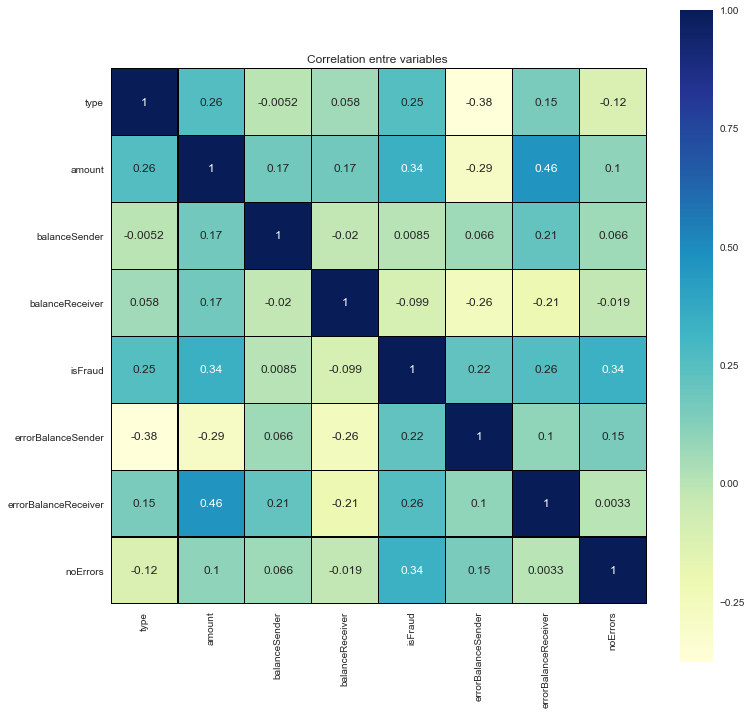

In [27]:
# affichage des corrélations entre variables
f, ax = plt.subplots(figsize=(12, 12))
plt.title('Correlation entre variables ')
sns.heatmap(d_model.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True)

* Parfait d'après ce qui precède l'independance de nos variables est bel et bien assurée car les variables ne sont pas corrélées.

# Commençons notre modèle

In [28]:
# y variable dependante et X variables dependantes
X = d_model.iloc[:, d_model.columns !='isFraud'].values
y = d_model.iloc[:, 4].values

In [29]:
# separation en donnees d'entrainement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# unification de l'echelle des données
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [30]:
"""
xTrainFraud = X_train.iloc[:,X_train.loc[:,'isFraud']==1]
sample = np.random.randint(0,xTrainFraud.shape[0]-1,100)
xTrainFraudAug = xTrainFraud.iloc[sample,:]
"""

"\nxTrainFraud = X_train.iloc[:,X_train.loc[:,'isFraud']==1]\nsample = np.random.randint(0,xTrainFraud.shape[0]-1,100)\nxTrainFraudAug = xTrainFraud.iloc[sample,:]\n"

In [31]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
#print(classifier.coef_)

In [33]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)


In [34]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


In [35]:
print(cm)

[[1830   17]
 [  90  191]]


* Ce resultat montre que nous avons eu 1830+191 BONNES PREDICTIONS et 90+17 MAUVAISES PREDICTIONS soit un score de 94.97%

 ##       Les variables de mon modèle sont toutes representatives?

In [36]:
# Ajouter une constante 1
import statsmodels.formula.api as sm
X_train = np.append(arr = np.ones((X_train.shape[0],1)).astype(int), values = X_train, axis = 1)



In [37]:
# sum up
import statsmodels.formula.api as sm
X_opt = X_train[:,[0,1,2,3,4,5,6,7]]
regressor_OLS = sm.OLS(endog = y_train, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     809.0
Date:                Fri, 07 Sep 2018   Prob (F-statistic):               0.00
Time:                        12:44:56   Log-Likelihood:                -578.63
No. Observations:                8512   AIC:                             1173.
Df Residuals:                    8504   BIC:                             1230.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1282      0.003     45.637      0.000       0.123       0.134
x1             0.1132      0.003     36.350      0.000       0.107       0.119
x2             0.1204      0.004     33.132      0.000       0.113       0.128
x3            -0.0337      0.003    -11.730      0.000      -0.039      -0.028
x4            -0.0252      0.003     -8.220      0.000      -0.031      -0.019
x5             0.1308      0.003     39.074      0.000       0.124       0.137
x6             0.0006      0.004      0.174      0.862      -0.006       0.008
x7             0.0978      0.003     33.616      0.000       0.092       0.104
==============================================================================
Omnibus:                     2479.552   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7440.037
Skew:                           1.511   Prob(JB):                         0.00
Kurtosis:                       6.441   Cond. No.                         2.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# on supprime la variable X6
X_opt = X_train[:,[0,1,2,3,4,5,7]]
regressor_OLS = sm.OLS(endog = y_train, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     943.9
Date:                Fri, 07 Sep 2018   Prob (F-statistic):               0.00
Time:                        12:44:56   Log-Likelihood:                -578.65
No. Observations:                8512   AIC:                             1171.
Df Residuals:                    8505   BIC:                             1221.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1282      0.003     45.640      0.000       0.123       0.134
x1             0.1133      0.003     36.648      0.000       0.107       0.119
x2             0.1207      0.003     39.188      0.000       0.115       0.127
x3            -0.0337      0.003    -11.781      0.000      -0.039      -0.028
x4            -0.0253      0.003     -8.648      0.000      -0.031      -0.020
x5             0.1309      0.003     40.525      0.000       0.125       0.137
x6             0.0978      0.003     33.798      0.000       0.092       0.103
==============================================================================
Omnibus:                     2477.816   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7430.364
Skew:                           1.511   Prob(JB):                         0.00
Kurtosis:                       6.439   Cond. No.                         1.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

La variable "errorBalanceReceiver" est peu représentative dans le modele

In [39]:
# m'a permis de faire le choix du modèle
"""from sklearn.model_selection import cross_val_score
def compute_score(clf,X,y):
    xval=cross_val_score(clf,X,y,cv=5)
    return mean(xval)
compute_score(classifier,X,y)
from sklearn.ensemble import RandomForestClassifier
nf=RandomForestClassifier()
compute_score(nf,X,y)
from sklearn.linear_model import LinearRegression
f= LinearRegression()
compute_score(f,X,y)
from sklearn.linear_model import LinearRegression
f= LinearRegression()
compute_score(f,X,y)
#CONSTRUCTION DU MODELE ARBRE DE DECISION
from sklearn.tree import DecisionTreeClassifier
abre=DecisionTreeClassifier(criterion='entropy',random_state=0)
compute_score(abre,X,y)"""

"from sklearn.model_selection import cross_val_score\ndef compute_score(clf,X,y):\n    xval=cross_val_score(clf,X,y,cv=5)\n    return mean(xval)\ncompute_score(classifier,X,y)\nfrom sklearn.ensemble import RandomForestClassifier\nnf=RandomForestClassifier()\ncompute_score(nf,X,y)\nfrom sklearn.linear_model import LinearRegression\nf= LinearRegression()\ncompute_score(f,X,y)\nfrom sklearn.linear_model import LinearRegression\nf= LinearRegression()\ncompute_score(f,X,y)\n#CONSTRUCTION DU MODELE ARBRE DE DECISION\nfrom sklearn.tree import DecisionTreeClassifier\nabre=DecisionTreeClassifier(criterion='entropy',random_state=0)\ncompute_score(abre,X,y)"